# Load packages and audio files

In [81]:
import scipy, matplotlib.pyplot as plt, librosa, IPython.display, urllib
import torch
import torchaudio
import torchaudio.transforms as transforms
import torchaudio.functional as F

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import glob
import seaborn as sns
plt.rcParams['figure.figsize'] = (14, 4)

### Segment audio files

In [12]:
# Load audio files

# All files and directories ending with .wav
filenames = glob.glob("data/car_test/*.wav")
label = ['B','B','T','N','N', 'N','V']
code = ['0','0','0','1','1', '1','0']

In [30]:
duration = [round(librosa.get_duration(filename=filename)*1000) for filename in filenames]
d_f_dict =list(zip(filenames, duration))
print(f'Filenames: duration in milliseconds: {d_f_dict}')

Filenames: duration in milliseconds: [('data/car_test\\Blinkers-hela.wav', 70476), ('data/car_test\\Blinkers-kort.wav', 26250), ('data/car_test\\Chit-chat.wav', 239707), ('data/car_test\\Normal 40-50.wav', 70322), ('data/car_test\\Normal 40-70.wav', 164272), ('data/car_test\\Normal 60.wav', 83859), ('data/car_test\\Vindrutetorkare.wav', 80300)]


In [33]:
d_f_dict[0][1]

70476

In [86]:
from pydub import AudioSegment
filenames_2 = []
label_2 = []
code_2 = []

for i in range(len(filenames)):
    dur = d_f_dict[i][1]
    l = label[i]
    c = code[i]
    j = round(duration[i]/10000)
    for k in range(j):
        start = k*10000
        end = (k+1)*10000
        sound = AudioSegment.from_wav(filenames[i])
        extract = sound[start:end]
        extract.export(f"data/output_{l}_{c}_{k}.wav", format="wav")
        filenames_2.append(f"data/output_{l}_{c}_{k}.wav")
        label_2.append(l)
        code_2.append(c)

print(filenames_2)

['data/output_B_0_0.wav', 'data/output_B_0_1.wav', 'data/output_B_0_2.wav', 'data/output_B_0_3.wav', 'data/output_B_0_4.wav', 'data/output_B_0_5.wav', 'data/output_B_0_6.wav', 'data/output_B_0_0.wav', 'data/output_B_0_1.wav', 'data/output_B_0_2.wav', 'data/output_T_0_0.wav', 'data/output_T_0_1.wav', 'data/output_T_0_2.wav', 'data/output_T_0_3.wav', 'data/output_T_0_4.wav', 'data/output_T_0_5.wav', 'data/output_T_0_6.wav', 'data/output_T_0_7.wav', 'data/output_T_0_8.wav', 'data/output_T_0_9.wav', 'data/output_T_0_10.wav', 'data/output_T_0_11.wav', 'data/output_T_0_12.wav', 'data/output_T_0_13.wav', 'data/output_T_0_14.wav', 'data/output_T_0_15.wav', 'data/output_T_0_16.wav', 'data/output_T_0_17.wav', 'data/output_T_0_18.wav', 'data/output_T_0_19.wav', 'data/output_T_0_20.wav', 'data/output_T_0_21.wav', 'data/output_T_0_22.wav', 'data/output_T_0_23.wav', 'data/output_N_1_0.wav', 'data/output_N_1_1.wav', 'data/output_N_1_2.wav', 'data/output_N_1_3.wav', 'data/output_N_1_4.wav', 'data/outp

In [87]:
# check if all files are 10 sec
duration_2 = [round(librosa.get_duration(filename=filename)*1000) for filename in filenames_2]
duration_2[0:10]

[10000, 10000, 6250, 10000, 10000, 10000, 10000, 10000, 10000, 6250]

In [88]:
# create dataframe full
frame = {'filename': filenames, 'label': label, 'code': code}
df = pd.DataFrame(frame)

# create dataframe segmented
frame = {'filename': filenames_2, 'label': label_2, 'code': code_2, 'duration': duration_2}
df_seg = pd.DataFrame(frame)
df_seg.tail()

,filename,label,code,duration
68,data/output_V_0_3.wav,V,0,10000
69,data/output_V_0_4.wav,V,0,10000
70,data/output_V_0_5.wav,V,0,10000
71,data/output_V_0_6.wav,V,0,10000
72,data/output_V_0_7.wav,V,0,10000


In [89]:
len(df_seg)

73

In [90]:
# Define function to load audio data
def load_audio(filename):
    waveform, sample_rate = torchaudio.load(filename, normalize=True)
    return waveform, sample_rate

In [68]:
load_audio(df_seg['filename'][3])

(tensor([[-0.0584, -0.0594, -0.0616,  ..., -0.0228, -0.0235, -0.0244]]), 48000)

In [53]:
# illustrate
from IPython.display import Audio
import librosa
import seaborn as sb
sb.set(style="white", palette="muted")


## plotting functions
def plot_waveform(waveform, sr, title="Waveform"):
    figure, axes = plt.subplots(1, 1)
    axes.set_title(title)
    axes.grid(True)
    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axes.plot(time_axis, waveform[0], linewidth=1)
    plt.show(block=False)

def plot_filtered_waveform(signal, filtered_signal):
    plt.plot(signal, label="Original")
    plt.plot(filtered_signal, label="Filtered")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

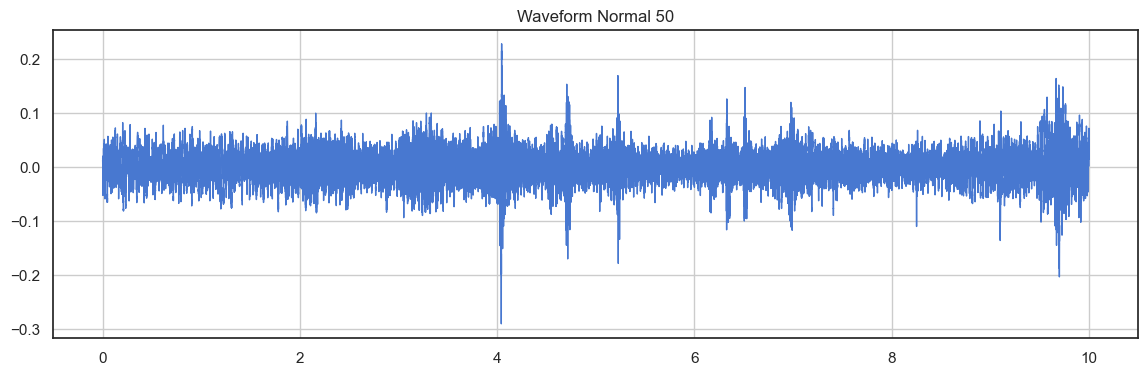

In [57]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'N'].iloc[1]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform Normal 50")
Audio(waveform.numpy(), rate=sample_rate)

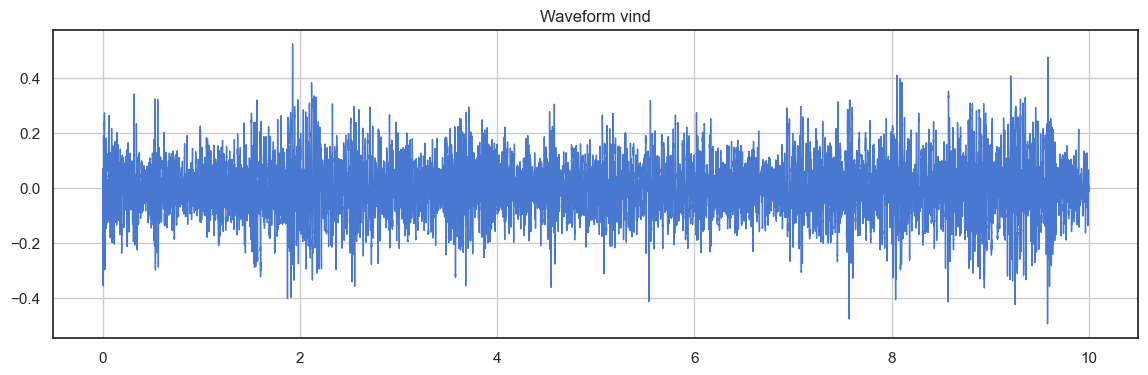

In [58]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'V'].iloc[1]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform vind")
Audio(waveform.numpy(), rate=sample_rate)

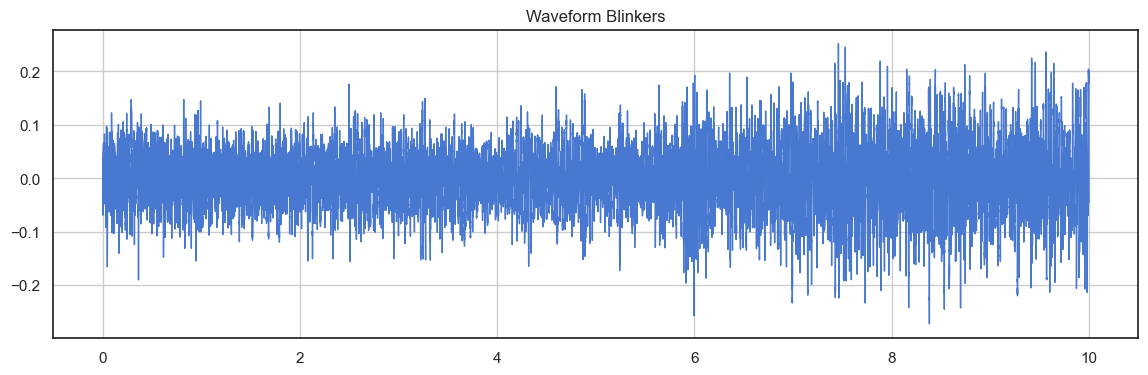

In [59]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'B'].iloc[5]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform Blinkers")
Audio(waveform.numpy(), rate=sample_rate)

In [75]:
def extract_cepstral_features(waveform, sample_rate):
    ''' MFCC - effective in capturing spectral features that are relevant to human perception
    Mean pitch - ? mean diffrence may be better '''
    sample_rate=48000
    n_fft = 2048
    win_length = round(0.3*n_fft)
    hop_length = round(0.2*n_fft)
    n_mfcc = 13
    mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sample_rate,n_mfcc=n_mfcc,
                                                melkwargs={
                                                    "n_fft": n_fft,
                                                    "win_length": win_length,
                                                    "hop_length": hop_length,
                                                },)

    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.mean(dim=2)

    pitch = F.detect_pitch_frequency(waveform, sample_rate).numpy()
    # Number of rows in mfcc
    n_rows = mfcc.shape[0]
    n_col = mfcc.shape[1]
    mfcc = mfcc.numpy()



    # # Subsample pitch to have the same number of rows as mfcc
    # pitch_subsampled = pitch[::pitch.shape[0]//n_rows]
    # # Concatenate arrays along the column axis (axis=1)
    # features = np.concatenate((pitch_subsampled, mfcc), axis=1)


    # Compute the mean of the pitch array
    mean_pitch = np.mean(pitch, axis =1)

    # Reshape the mean pitch to a 2D array with the same number of rows as mfcc
    mean_pitch = np.reshape(mean_pitch, (mfcc.shape[0],1))

    # Concatenate the mean pitch with the mfcc array along the column axis (axis=1)
    features = np.concatenate((mean_pitch, mfcc), axis=1)



    # gfcc_transform = torchaudio.transforms.GFCC(sample_rate=sample_rate)
    # gfcc = gfcc_transform(waveform)
    # gfcc = gfcc.mean(dim=2)

    return features.flatten()

In [76]:
cepstral_features = [extract_cepstral_features(load_audio(filename)[0],load_audio(filename)[1]) for filename in filenames_2]

 1    61
-1    12
Name: code_if, dtype: int64

KeyError: 'f'

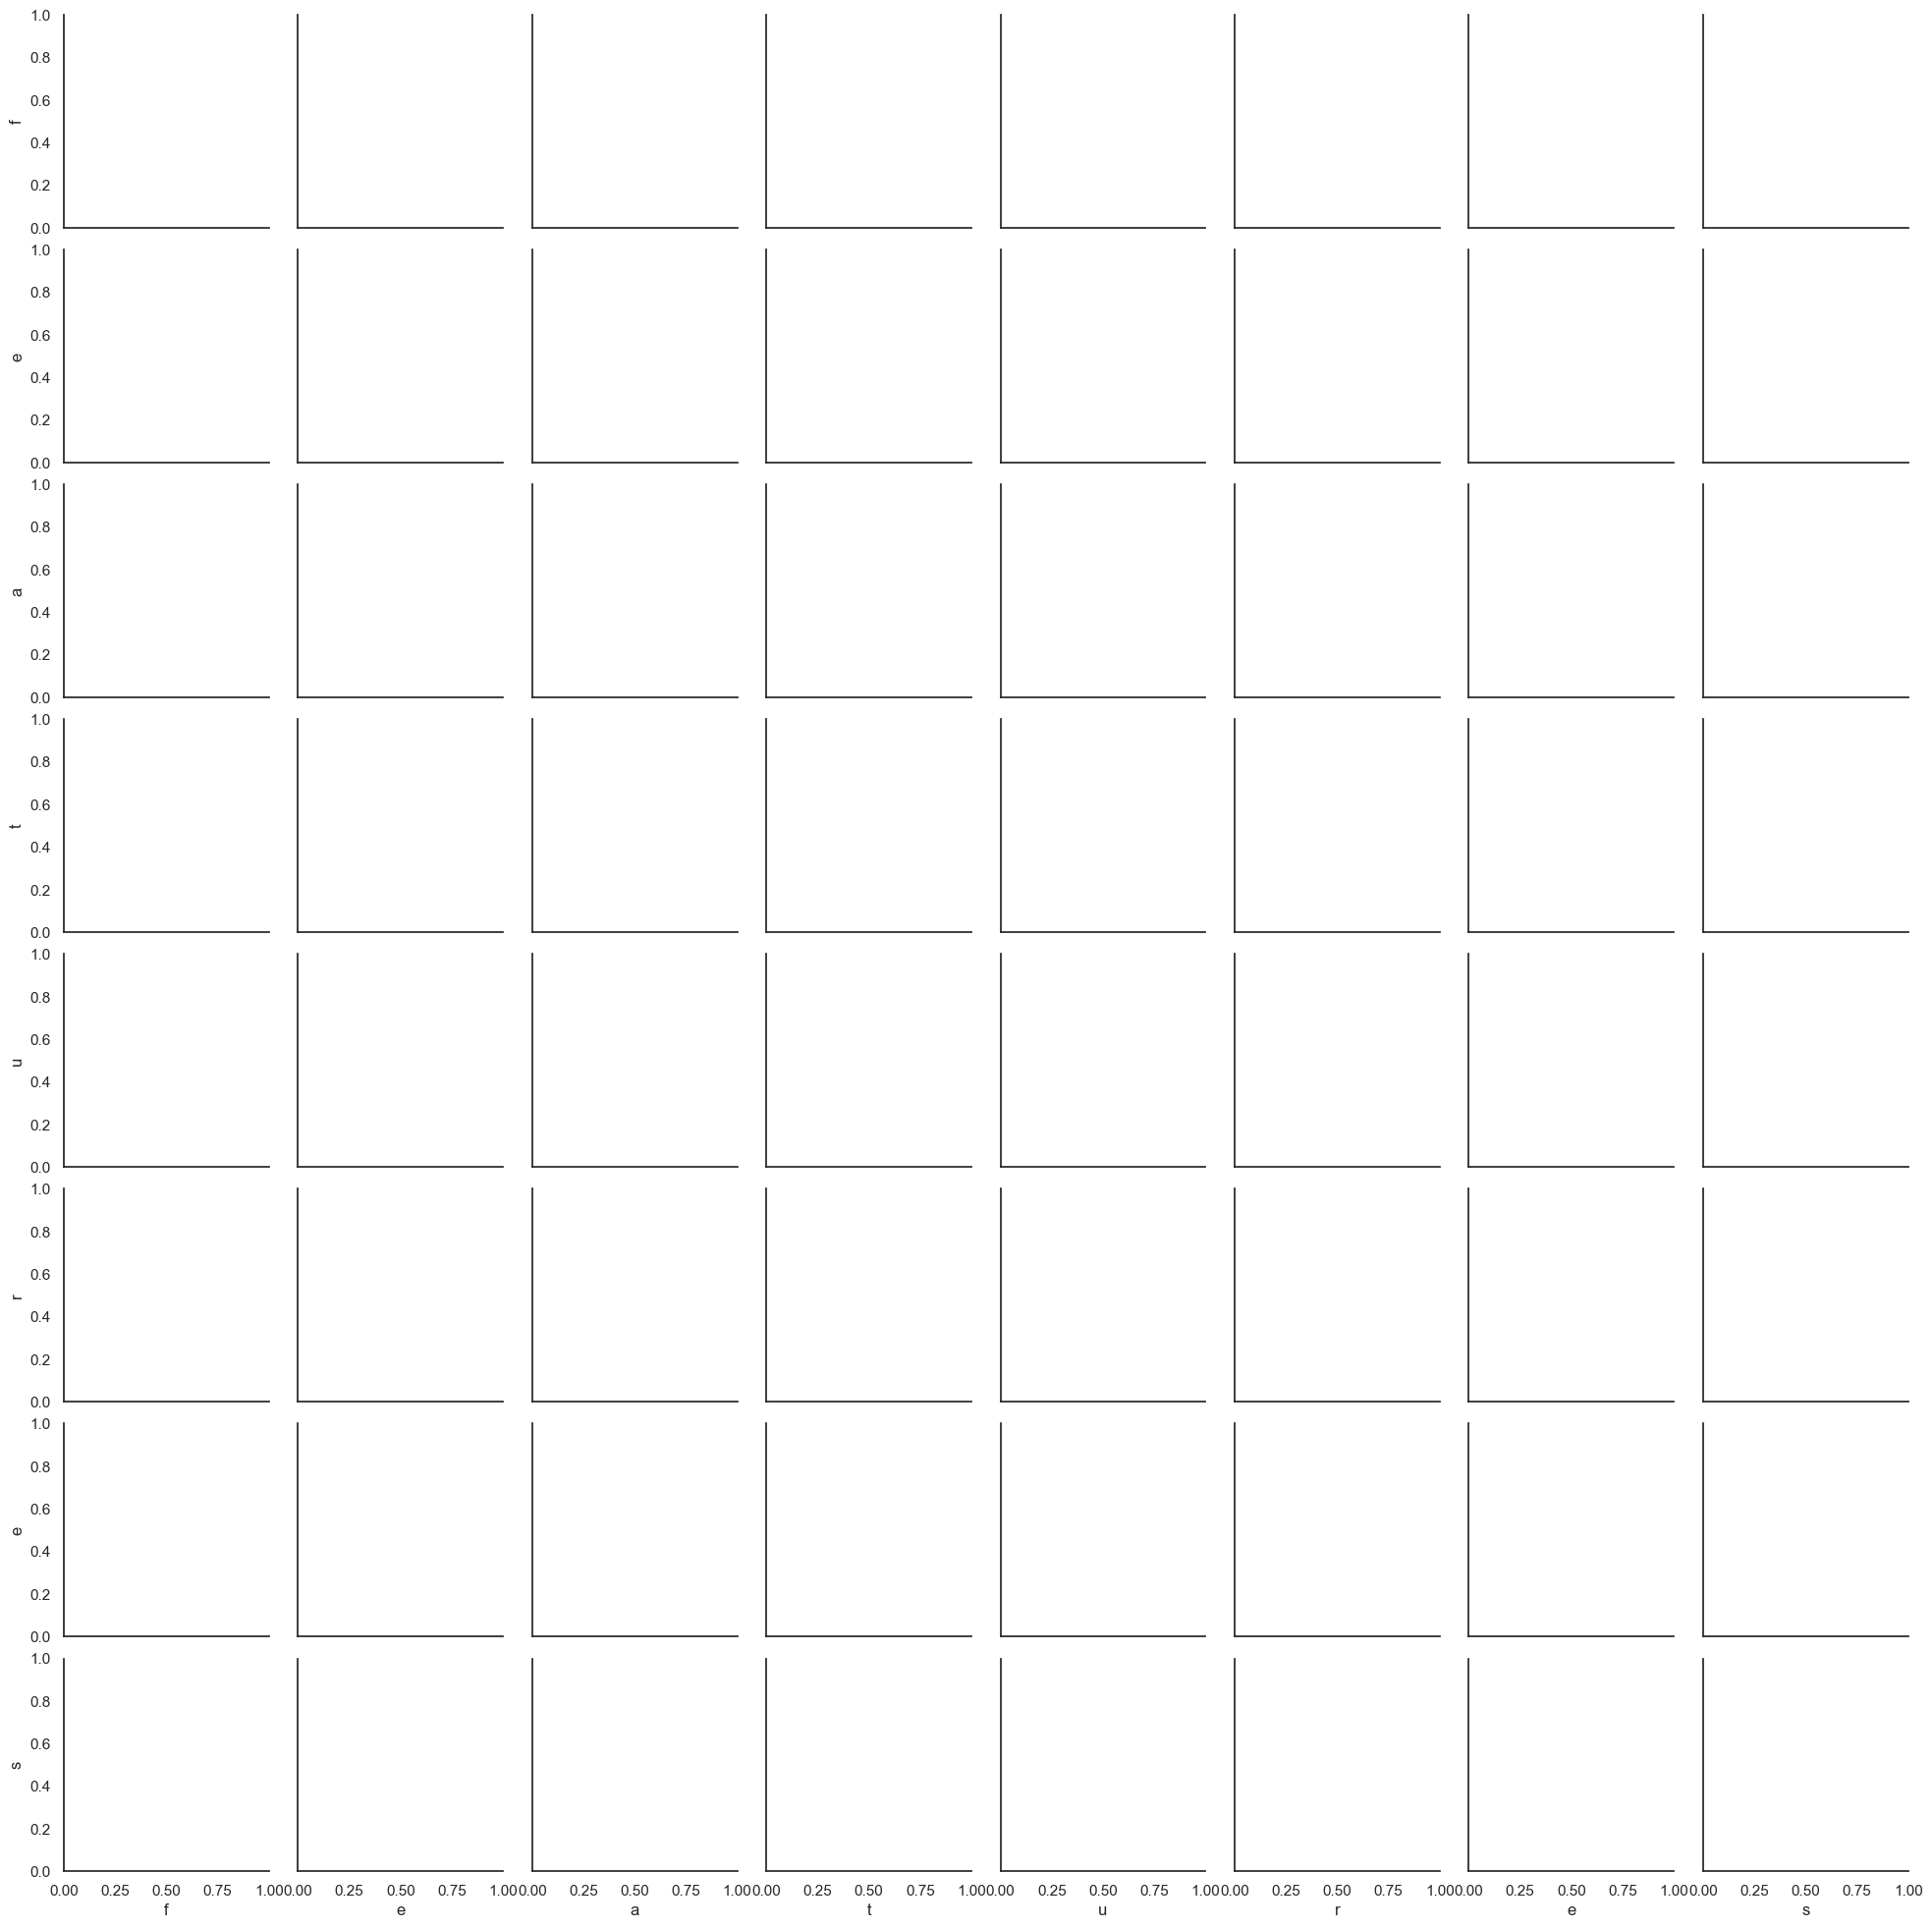